In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from micron2.clustering import Encoder, train_moco
from micron2.data import stream_dataset

import h5py
import tqdm.auto as tqdm

/home/ingn/devel/micron2/micron2/clustering/utils.py:16: UserWarning: Failed to import GPU tools. Accelerated neighbors/leiden/t-SNE/UMAP will not be unavailable
  warnings.warn('Failed to import GPU tools. Accelerated neighbors/leiden/t-SNE/UMAP will not be unavailable')
/home/ingn/devel/micron2/micron2/spatial/utils.py:11: UserWarning: Failed to load RAPIDS cuda-enabled tools.
  warnings.warn("Failed to load RAPIDS cuda-enabled tools.")


In [2]:
!ls /home/ingn/tmp/micron2-data

joined_dataset.hdf5  moco  moco-cells


In [3]:
crop_size = 48
# use_channels = ['DAPI', 'CD45', 'PanCytoK', 'CD3e', 'CD4', 'CD8', 'PDGFRb', 'CD20', 'CD68', 'IgG', 'C1q']

with h5py.File('/home/ingn/tmp/micron2-data/joined_dataset.hdf5', 'r') as f:
    all_channels = [b.decode('UTF-8') for b in f['meta/channel_names'][:]]
    print(all_channels)
    
    # just use all the channels
    use_channels = all_channels

    means = tf.constant([f[f'cell_intensity/{c}'].attrs['mean'] for c in use_channels], dtype=tf.float32)
    stds =  tf.constant([f[f'cell_intensity/{c}'].attrs['std'] for c in use_channels], dtype=tf.float32)
    print(means)
    print(stds)


['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']
tf.Tensor(
[4.03521284e-02 1.56009267e-03 3.80972982e-03 7.41325028e-04
 2.18258538e-06 2.94799940e-03 8.33688420e-04 1.31129893e-02
 3.91811766e-02 1.51037591e-06 7.50164734e-04 1.13088422e-01
 5.24967210e-04 1.45652157e-05 1.02015865e-05 2.21496403e-01
 3.46743298e-04 1.77023932e-02 3.68218054e-04 8.11160426e-04
 2.60041095e-02 9.20398361e-06 1.50515575e+01 3.63372010e-03
 9.30123380e-04 1.49623051e-01 1.15755902e-05 1.52418797e-03
 2.97930002e-01 9.33473289e-04 2.34060502e-03 5.37125743e-04
 1.70752604e-03 2.24937452e-03 3.98730799e-06 4.62812051e-04
 1.52671030e-02 3.76521461e-02 1.20869847e-02 4.72583924e-04], shape=(40,), dtype=float32)
tf.Tensor

In [4]:
outdir = '/home/ingn/tmp/micron2-data/moco-cells'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
with open(f'{outdir}/use_channels.txt', 'w+') as f:
    for c in use_channels:
        f.write(f'{c}\n')
        
# import os
# if os.path.exists(f'{outdir}/weights.h5'):
#     model.load_weights(f'{outdir}/weights.h5')

In [5]:
print(use_channels)

def process(x):
    """
    x is [N, h, w, c]
    """
    x = tf.cast(x, tf.float32)
    x = (x - means) / stds
    
#     x = tf.cast(x, tf.float32)/255.
#     x = tf.transpose(tf.image.per_image_standardization(tf.transpose(x)))
    return x
    
# Create a dataset with infinite repeating 
dataset = stream_dataset('/home/ingn/tmp/micron2-data/joined_dataset.hdf5', 
                         use_channels=use_channels,
                         group_name='cells' )
dataset = (dataset.repeat(None)
           .shuffle(1024 * 5)
           .map(process, num_parallel_calls=8)
           .batch(32)
           .prefetch(16)
           #.apply(tf.data.experimental.prefetch_to_device("/gpu:0"))
          )

# for sample_x in dataset:
#     break
    
# print(sample_x.shape)
# for k in range(sample_x.shape[-1]):
#     print(use_channels[k], sample_x.numpy()[...,k].mean())

['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']


In [6]:
# sample_x = tf.image.random_crop(sample_x, size=(sample_x.shape[0], 
#                                                 crop_size, crop_size, 
#                                                 sample_x.shape[-1]))

In [7]:
sample_x = tf.zeros([1, 64, 64, len(use_channels)],dtype=tf.float32)
model = Encoder(input_shape=[crop_size, crop_size, len(use_channels)])
y, z_g = model(sample_x, return_g=True)
print(y.shape)
print(z_g.shape)
z = model.encode(sample_x)
print(z.shape)

model.summary()

/home/ingn/miniconda3/envs/micron2-tf/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 40 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


(1, 128)
(1, 32)
(1, 128)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     multiple                  0         
_________________________________________________________________
random_rotation (RandomRotat multiple                  0         
_________________________________________________________________
random_translation (RandomTr multiple                  0         
_________________________________________________________________
random_crop (RandomCrop)     multiple                  0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2, 2, 2048)        23680832  
_________________________________________________________________
conv2d (Conv2D)              multiple                  4194816   
_________________________________________________________________
flatten (Flatten)            mult

In [8]:
# # Placing the key encoder on CPU helps training speed, maybe
with tf.device('/CPU:0'):
# kmodel = Encoder(input_shape=sample_x.shape[1:])
    kmodel = Encoder(input_shape=[crop_size, crop_size, len(use_channels)])
    y, z_g = kmodel(sample_x, return_g=True)
    print(y.shape)
    print(z_g.shape)
    z = kmodel.encode(sample_x)
    print(z.shape)

kmodel.summary()

(1, 128)
(1, 32)
(1, 128)
Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   multiple                  0         
_________________________________________________________________
random_rotation_1 (RandomRot multiple                  0         
_________________________________________________________________
random_translation_1 (Random multiple                  0         
_________________________________________________________________
random_crop_1 (RandomCrop)   multiple                  0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2, 2, 2048)        23680832  
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4194816   
_________________________________________________________________
flatten_1 (Flatten)          mu

In [9]:
loss_history = train_moco(dataset, model, kmodel, 
                          lr=1e-4,
                          max_queue_len=128, 
                          crop_size=crop_size,
                          max_steps=2e5, temp=0.1,
                          perturb=False
                         )

Initializing the key queue


  0%|          | 0/200000 [00:00<?, ?it/s]

Start training


<ipython-input-10-d57f9e820f29>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(lh), np.log10(loss_history), lw=0.1)


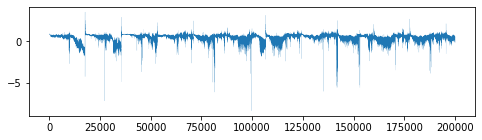

In [10]:
from matplotlib import pyplot as plt
lh = len(loss_history)
plt.figure(figsize=(8,2))
plt.plot(np.arange(lh), np.log10(loss_history), lw=0.1)

In [11]:
model.save_weights(f'{outdir}/weights.h5')
np.save(f'{outdir}/loss_history.npy', np.array(loss_history),)

# Process a whole dataset

In [12]:
# crop_frac = crop_size / 64
# def process_crop(x):
#     """
#     x is [N, h, w, c]
#     """
#     x = tf.cast(x, tf.float32)
#     x = (x - means) / stds
    
# #     x = tf.cast(x, tf.float32)/255.
# #     x = tf.transpose(tf.image.per_image_standardization(tf.transpose(x)))
#     x = tf.image.central_crop(x, crop_frac)
#     return x

# dataset = stream_dataset('/home/ingn/tmp/micron2-data/joined_dataset.hdf5', 
#                          use_channels=use_channels,
#                          group_name='tiles'
#                         )
# dataset = (dataset.map(process_crop, num_parallel_calls=8)
#            .batch(128)
#            .prefetch(4)
#           )

# z = []
# for batch in tqdm.tqdm(dataset):
#     z.append(model.encode(batch, training=False).numpy())
    
# z = np.concatenate(z, axis=0)
# print(z.shape)

InvalidArgumentError: slice index 0 of dimension 0 out of bounds. [Op:StridedSlice] name: IOFromHDF5/HDF5IODataset/strided_slice/

In [ ]:
# np.save(f'{outdir}/z.npy', z)